[[ 0.00000000e+00  1.00000000e+00  0.00000000e+00 ...  1.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 7.81831482e-01  6.23489802e-01  9.74927912e-01 ... -9.00968868e-01
  -4.33883739e-01 -9.00968868e-01]
 [ 9.74927912e-01 -2.22520934e-01 -4.33883739e-01 ...  6.23489802e-01
   7.81831482e-01  6.23489802e-01]
 ...
 [-9.74927912e-01 -2.22520934e-01  4.33883739e-01 ...  6.23489802e-01
  -7.81831482e-01  6.23489802e-01]
 [-7.81831482e-01  6.23489802e-01 -9.74927912e-01 ... -9.00968868e-01
   4.33883739e-01 -9.00968868e-01]
 [-4.11580361e-14  1.00000000e+00 -8.23160723e-14 ...  1.00000000e+00
  -1.64632145e-13  1.00000000e+00]]


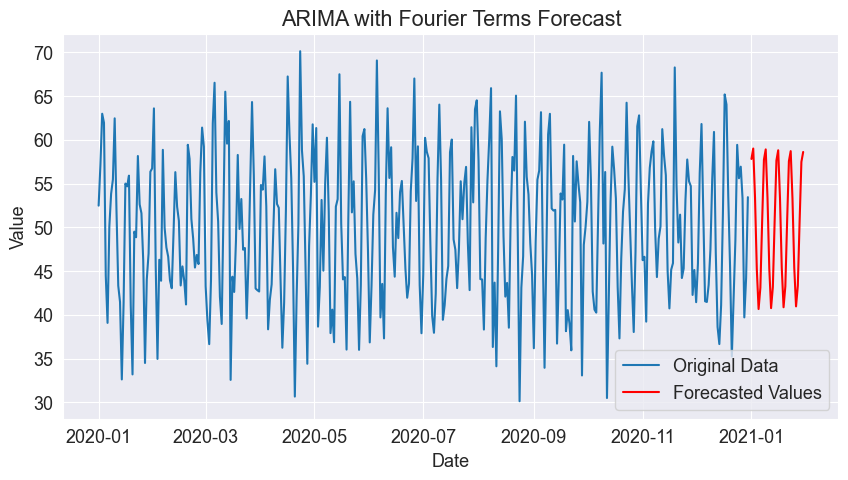

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
# Generate synthetic time series data with daily seasonality
np.random.seed(42)
n = 365  # Number of data points
t = np.arange(n)
seasonality = 7  # Weekly seasonality
data = 50 + 10 * np.sin(2 * np.pi * t / seasonality) + np.random.normal(0, 5, n)

# Convert the data to a pandas DataFrame
df = pd.DataFrame({'Date': pd.date_range(start='2020-01-01', periods=n), 'Value': data})
df.set_index('Date', inplace=True)

# Create Fourier terms for weekly seasonality
def create_fourier_terms(t, period, num_terms):
    terms = []
    for i in range(1, num_terms + 1):
        terms.append(np.sin(2 * np.pi * i * t / period))
        terms.append(np.cos(2 * np.pi * i * t / period))
    return np.column_stack(terms)

num_fourier_terms = 4
fourier_terms = create_fourier_terms(t, seasonality, num_fourier_terms)

print(fourier_terms)

# Fit the ARIMA model using pmdarima's auto_arima with Fourier terms as exogenous variables
model = auto_arima(df['Value'],exogenous=fourier_terms[:n], seasonal=True, suppress_warnings=True)
model.fit(df['Value'], exogenous=fourier_terms[:n])

# Forecast future values with the fitted model
forecast_steps =30
forecast_exog = create_fourier_terms(np.arange(n, n + forecast_steps), seasonality, num_fourier_terms)

# Get the forecast for the future steps with exogenous variables
forecast_df = pd.DataFrame(forecast_exog, columns=[f'Fourier_{i+1}' for i in range(num_fourier_terms * 2)])
#forecast_values = model.predict(n_periods=forecast_steps)
forecast_values = model.predict(n_periods=forecast_steps, exogenous=forecast_df)

# Retrieve the index for forecasting
forecast_index = pd.date_range(start='2021-01-01', periods=forecast_steps)

# Plot the original data and the forecasted values
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Value'], label='Original Data')
plt.plot(forecast_index, forecast_values, label='Forecasted Values', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA with Fourier Terms Forecast')
plt.legend()
plt.show()

# Seasonal-Trend decomposition using LOESS (STL)

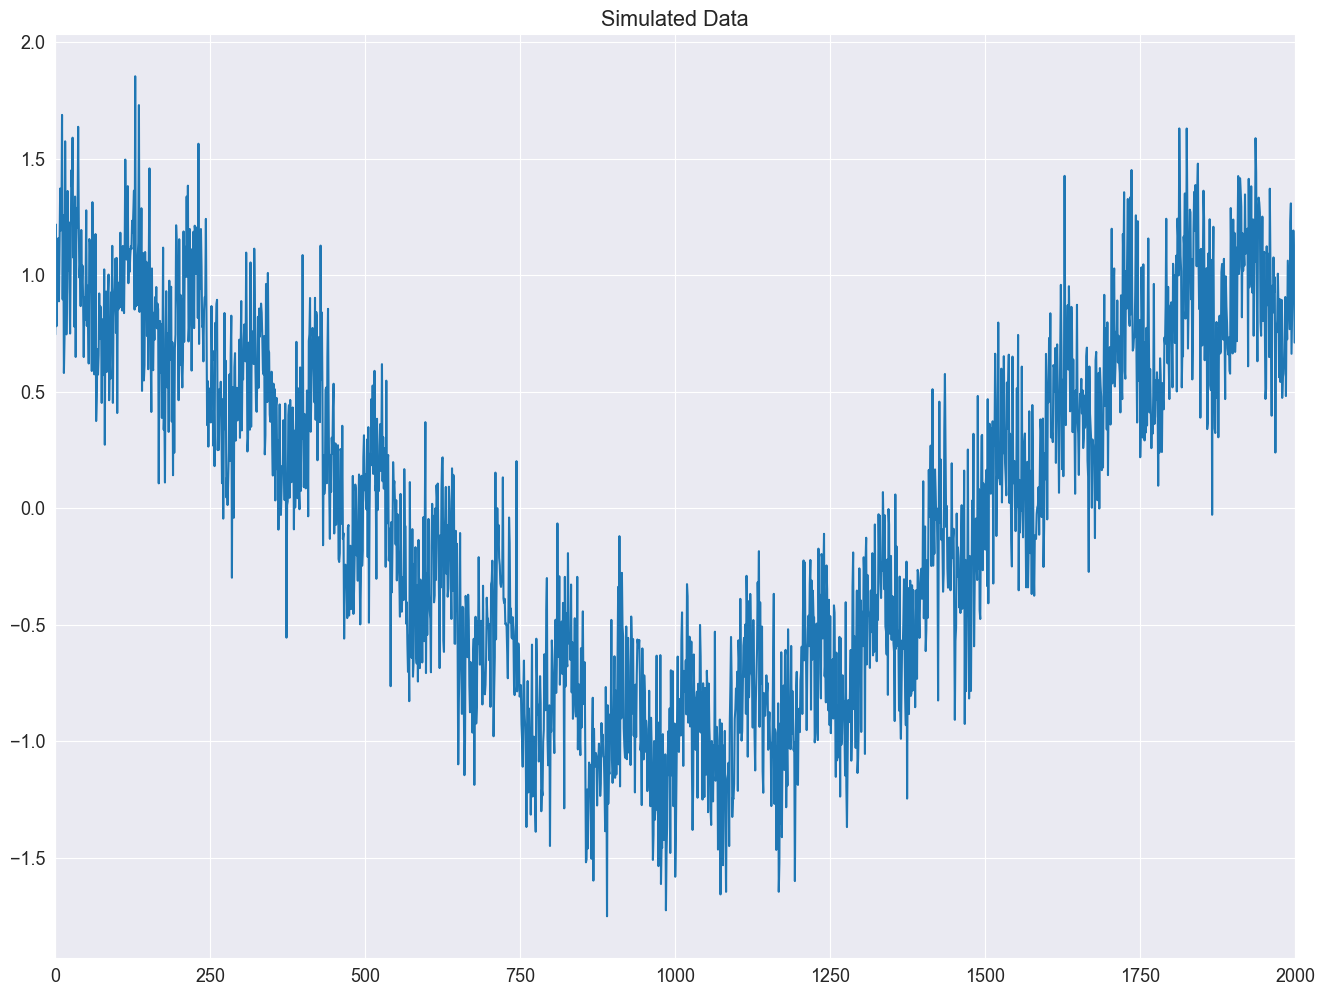

In [88]:
import numpy as np

rs = np.random.RandomState(0xA4FD94BC)
tau = 2000
t = np.arange(tau)
period = int(0.05 * tau)
seasonal = period + ((period % 2) == 0)  # Ensure odd
e = 0.25 * rs.standard_normal(tau)
y = np.cos(t / tau * 2 * np.pi) + 0.25 * np.sin(t / period * 2 * np.pi) + e
plt.plot(y)
plt.title("Simulated Data")
xlim = plt.gca().set_xlim(0, tau)

77.7 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


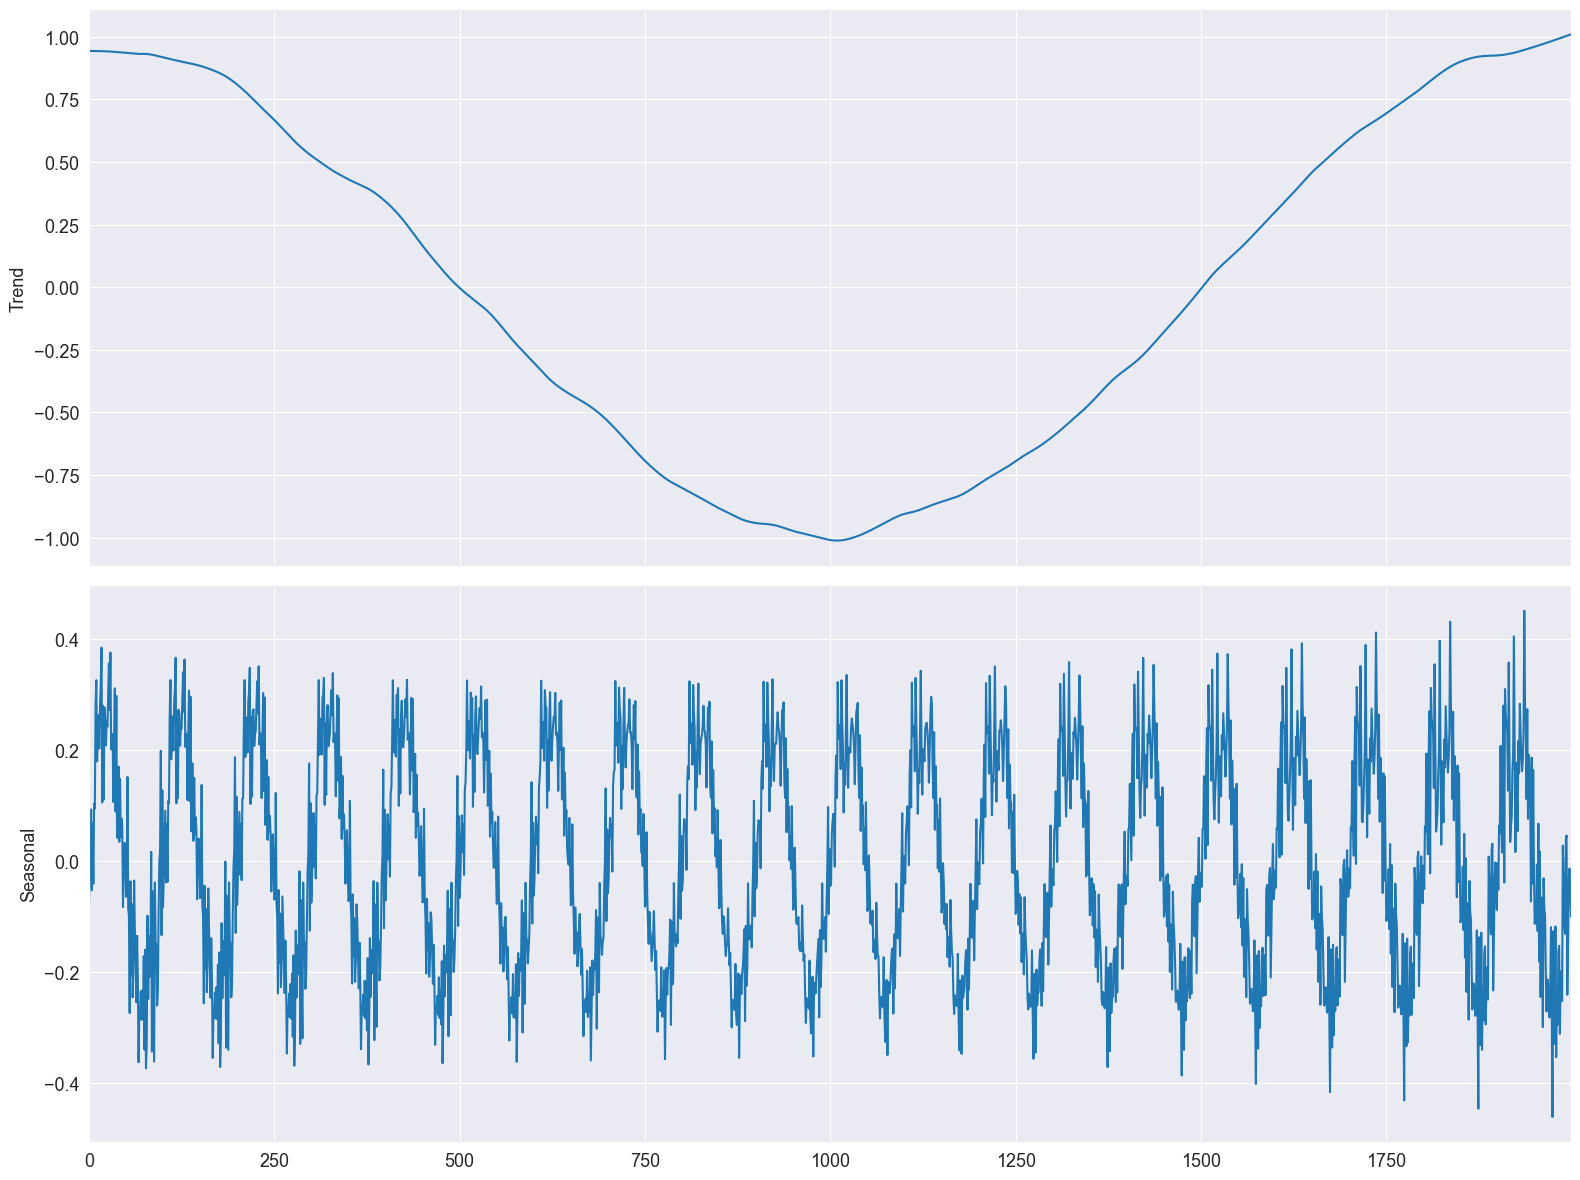

In [89]:

from statsmodels.tsa.stl._stl import STL

mod = STL(y, period=period, seasonal=seasonal)
%timeit mod.fit()
res = mod.fit()
fig = res.plot(observed=False, resid=False)

In [90]:
res

# Multiple Seasonal-Trend decomposition using LOESS (MSTL)

In [5]:
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

register_matplotlib_converters()
sns.set_style("darkgrid")

In [6]:
plt.rc("figure", figsize=(16, 12))
plt.rc("font", size=13)

In [7]:
t = np.arange(1, 1000)
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
trend = 0.0001 * t**2
y = trend + daily_seasonality + weekly_seasonality + np.random.randn(len(t))
ts = pd.date_range(start="2020-01-01", freq="H", periods=len(t))
df = pd.DataFrame(data=y, index=ts, columns=["y"])

In [8]:
df.head()


,y
2020-01-01 00:00:00,1.266887
2020-01-01 01:00:00,3.471793
2020-01-01 02:00:00,4.668671
2020-01-01 03:00:00,5.919826
2020-01-01 04:00:00,5.918235


<Axes: >

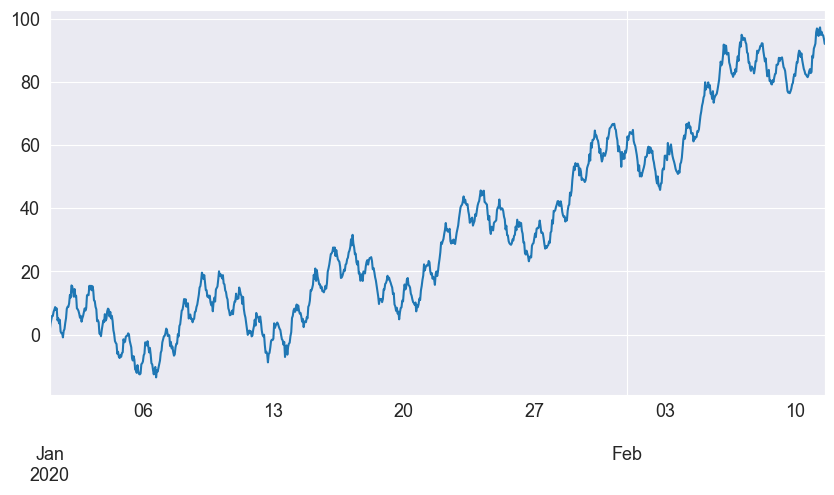

In [9]:
df["y"].plot(figsize=[10, 5])


In [10]:

mstl = MSTL(df["y"], periods=[24, 24 * 7])
res = mstl.fit()

In [11]:
res.seasonal.head()


,seasonal_24,seasonal_168
2020-01-01 00:00:00,1.000390,1.123100
2020-01-01 01:00:00,2.046695,1.575569
2020-01-01 02:00:00,3.493247,1.370960
2020-01-01 03:00:00,4.529483,1.481135
2020-01-01 04:00:00,4.775096,1.736522


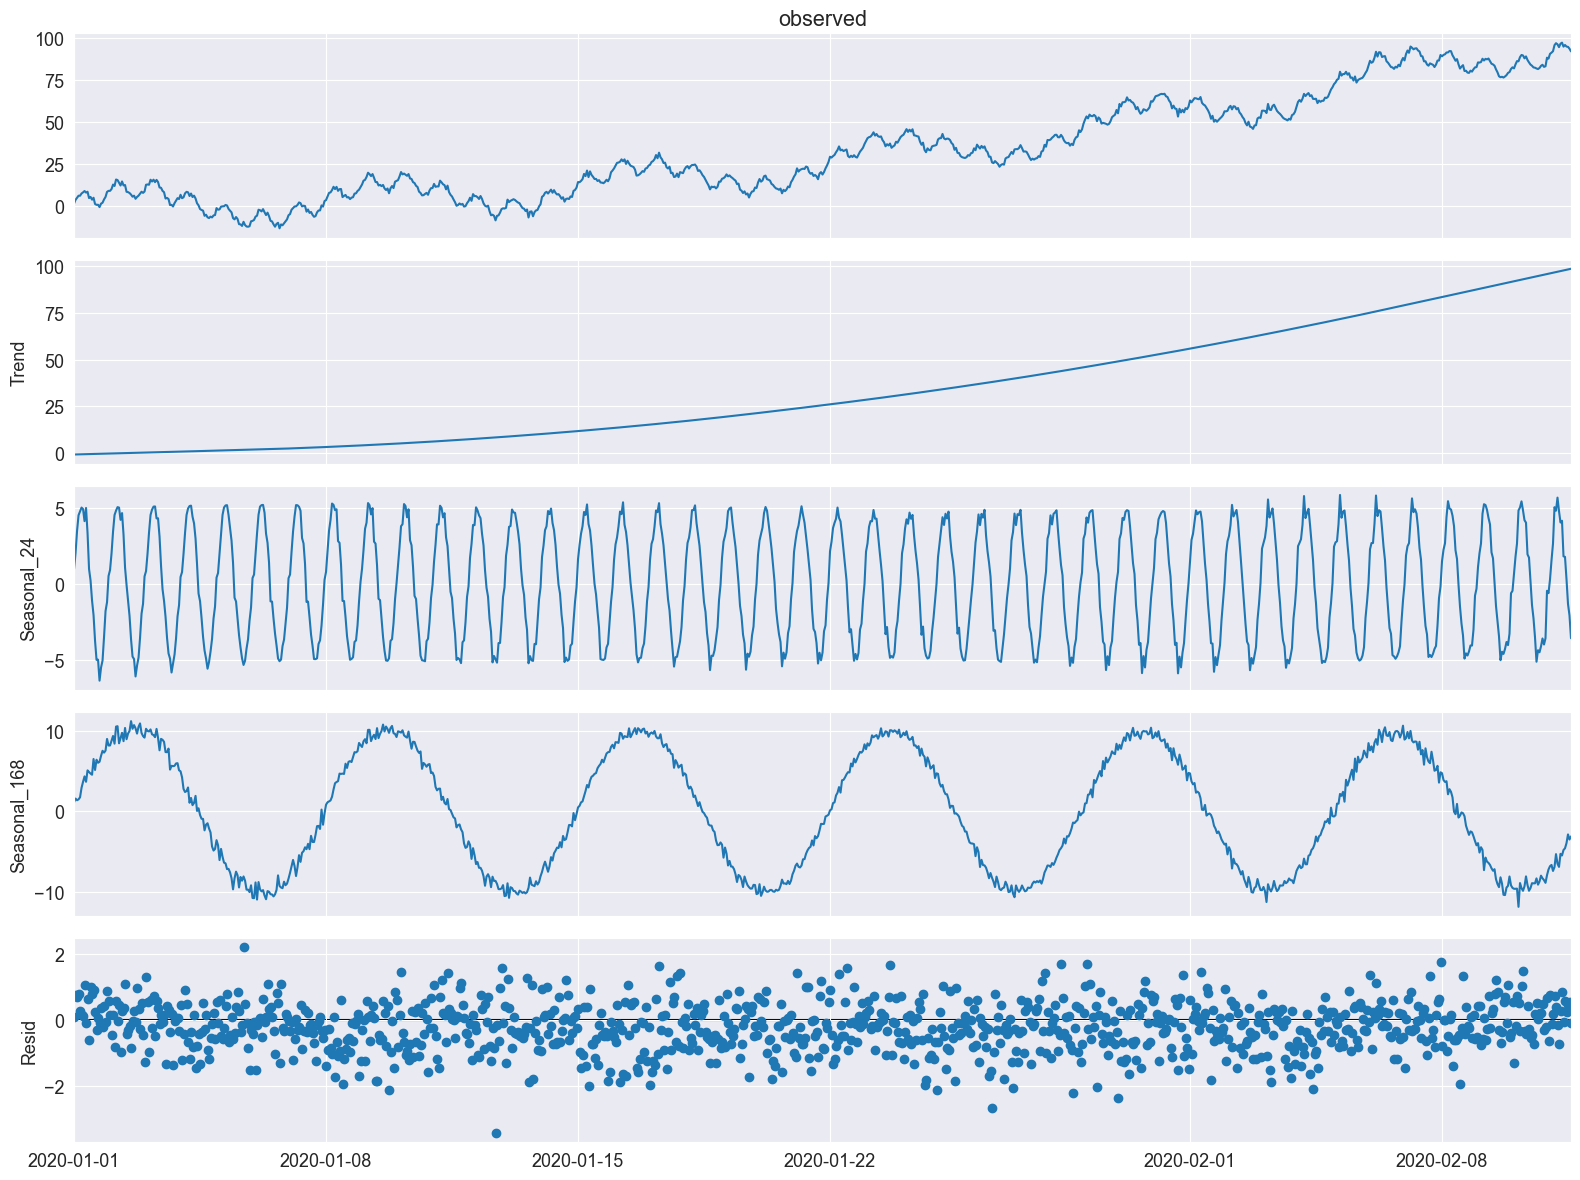

In [12]:
ax = res.plot()


# MSTL Using Energy data (Australia)

In [13]:
url = "https://raw.githubusercontent.com/tidyverts/tsibbledata/master/data-raw/vic_elec/VIC2015/demand.csv"
df = pd.read_csv(url)

In [14]:

df.head()

,Date,Period,OperationalLessIndustrial,Industrial
0,37257,1,3535.867064,1086.132936
1,37257,2,3383.499028,1088.500972
2,37257,3,3655.527552,1084.472448
3,37257,4,3510.446636,1085.553364
4,37257,5,3294.697156,1081.302844


In [15]:
df["Date"] = df["Date"].apply(lambda x: pd.Timestamp("1899-12-30") + pd.Timedelta(x, unit="days"))
df["ds"] = df["Date"] + pd.to_timedelta((df["Period"]-1)*30, unit="m")


In [16]:
timeseries = df[["ds", "OperationalLessIndustrial"]]
timeseries.columns = ["ds", "y"] # Rename to OperationalLessIndustrial to y for simplicity.

# Filter for first 149 days of 2012.
start_date = pd.to_datetime("2012-01-01")
end_date = start_date + pd.Timedelta("149D")
mask = (timeseries["ds"] >= start_date) & (timeseries["ds"] < end_date)
timeseries = timeseries[mask]

# Resample to hourly
timeseries = timeseries.set_index("ds").resample("H").sum()
timeseries.head()


,y
ds,
2012-01-01 00:00:00,7926.529376
2012-01-01 01:00:00,7901.826990
2012-01-01 02:00:00,7255.721350
2012-01-01 03:00:00,6792.503352
2012-01-01 04:00:00,6635.984460


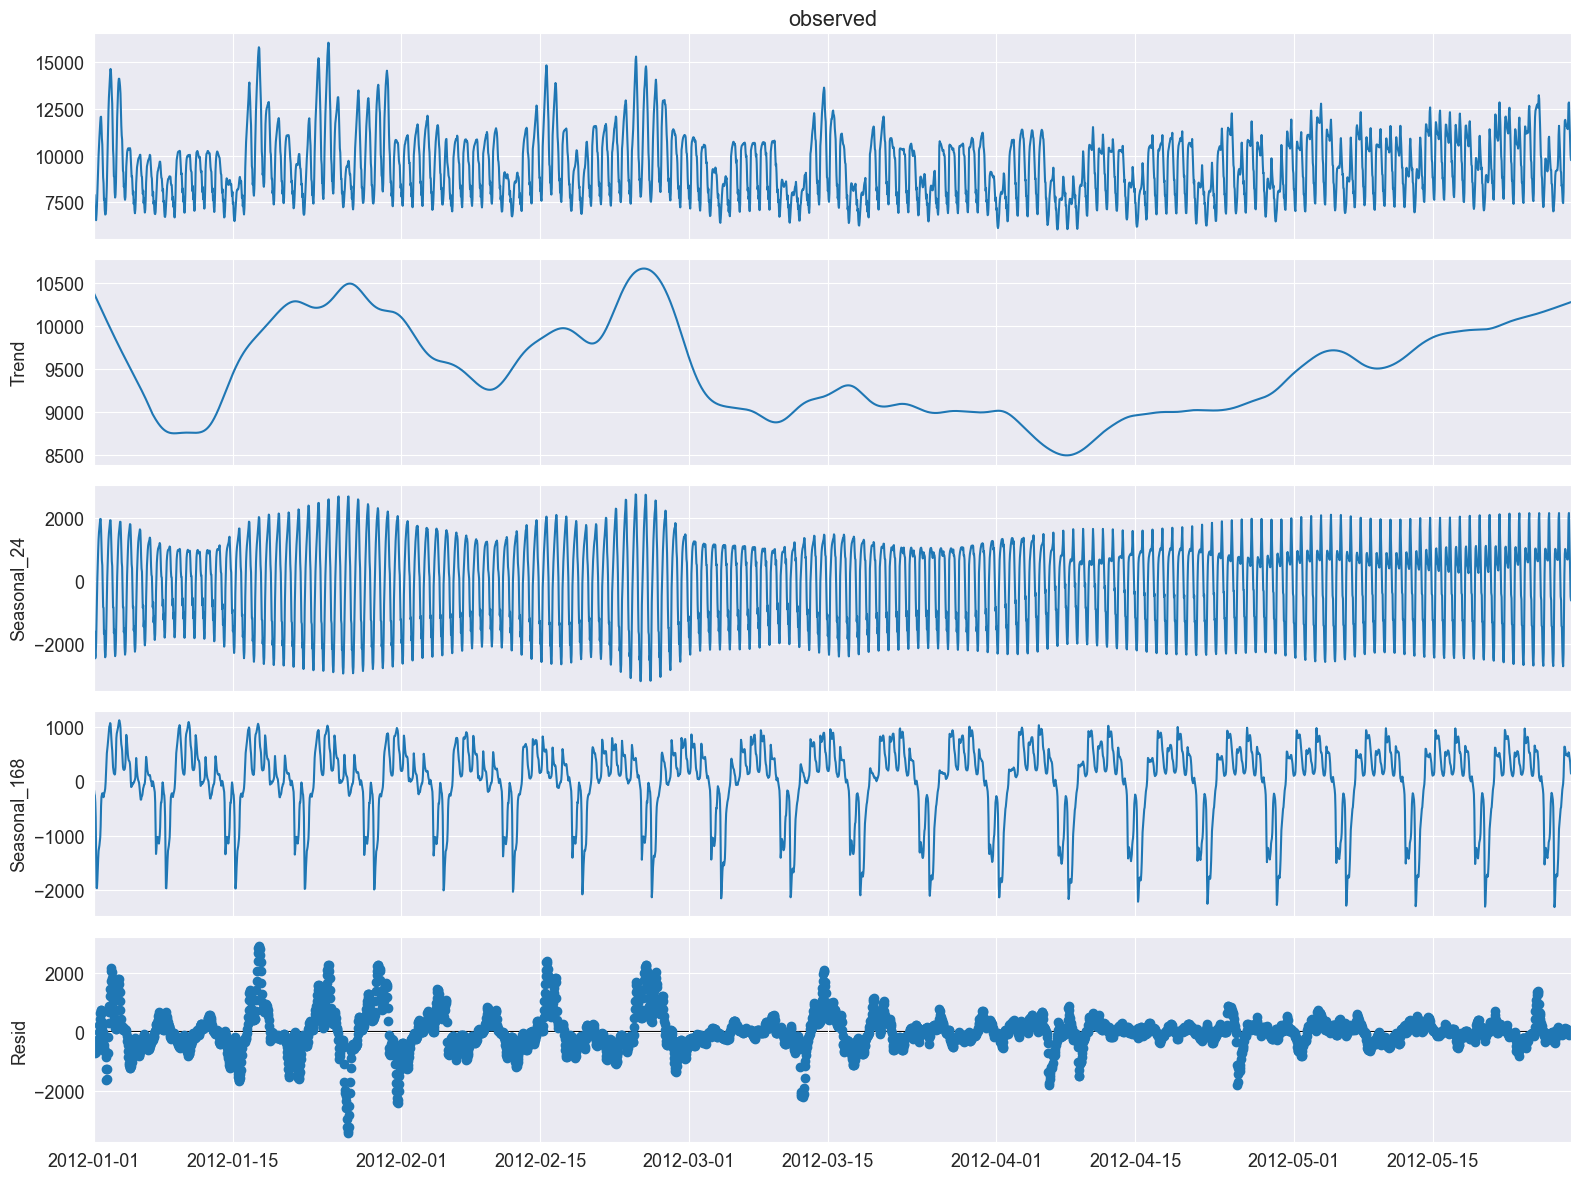

In [17]:
mstl = MSTL(timeseries["y"], periods=[24, 24 * 7], iterate=3, stl_kwargs={"seasonal_deg": 0,
                                                                          "inner_iter": 2,
                                                                          "outer_iter": 0})
res = mstl.fit() # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()


In [18]:
res.seasonal

,seasonal_24,seasonal_168
ds,,
2012-01-01 00:00:00,-1685.986297,-161.807086
2012-01-01 01:00:00,-1591.640845,-229.788887
2012-01-01 02:00:00,-2192.989492,-260.121300
2012-01-01 03:00:00,-2442.169359,-388.484499
2012-01-01 04:00:00,-2357.492551,-660.245476
...,...,...
2012-05-28 19:00:00,1534.555019,474.111504
2012-05-28 20:00:00,975.199465,411.048278
2012-05-28 21:00:00,240.882025,355.233651


# Doing the same for out energy data

In [50]:
from Energy.HelpFunctions.get_energy_data import get_energy_data, prepare_data

df = get_energy_data()
df = prepare_data(df)

start_date = pd.to_datetime("2020-01-01")
end_date = pd.to_datetime("2023-12-31")

mask = (df.index >= start_date) & (df.index < end_date)
df = df[mask]

In [13]:
df

,gesamt
date_time,
2018-12-24 00:00:00,42.02925
2018-12-24 01:00:00,39.61025
2018-12-24 02:00:00,39.13875
2018-12-24 03:00:00,39.42100
2018-12-24 04:00:00,40.74775
...,...
2024-01-02 07:00:00,52.00425
2024-01-02 08:00:00,55.73700
2024-01-02 09:00:00,56.98175


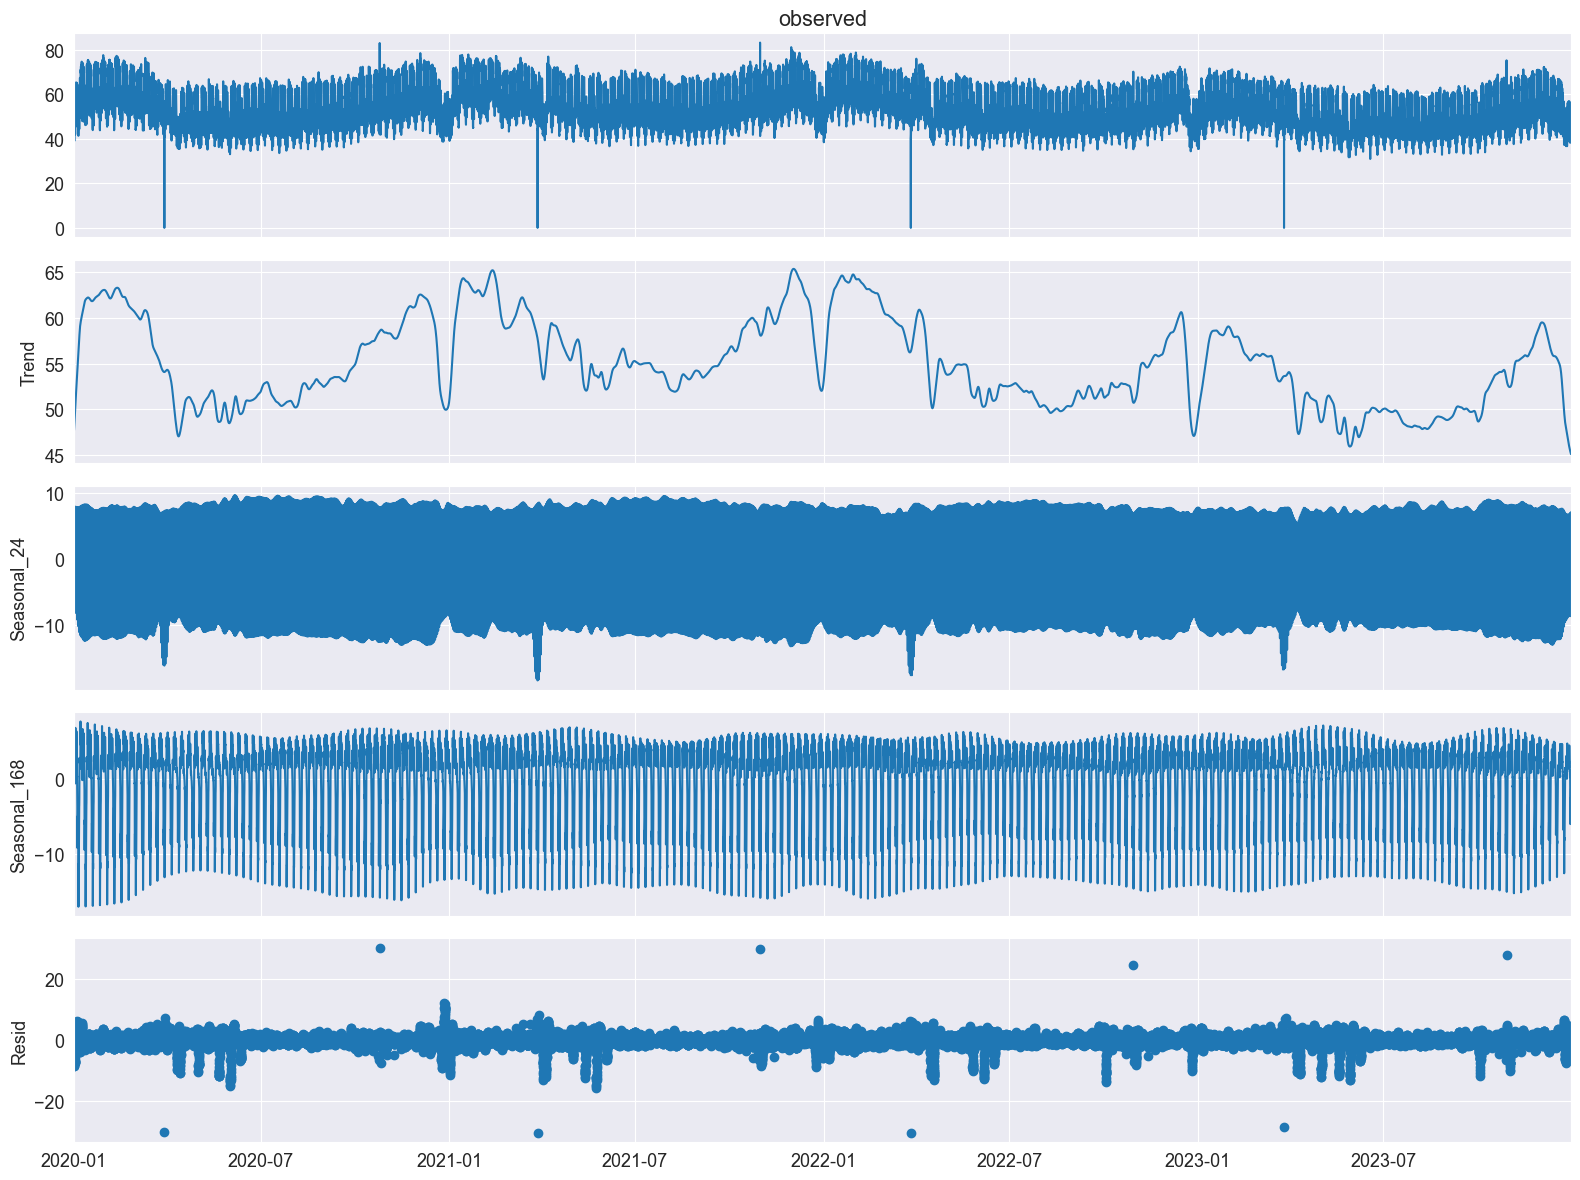

In [52]:
mstl = MSTL(df['gesamt'], periods=[24, 24 * 7], iterate=3)
res = mstl.fit() # Use .fit() to perform and return the decomposition
ax = res.plot()
plt.tight_layout()
plt.savefig(f'../plots/MSLT.png')
plt.show()

In [41]:
object_methods = [f'{method_name}: {callable(getattr(res, method_name))}' for method_name in dir(res)]

In [42]:
object_methods

['__class__: True',
 '__delattr__: True',
 '__dict__: False',
 '__dir__: True',
 '__doc__: False',
 '__eq__: True',
 '__format__: True',
 '__ge__: True',
 '__getattribute__: True',
 '__gt__: True',
 '__hash__: True',
 '__init__: True',
 '__init_subclass__: True',
 '__le__: True',
 '__lt__: True',
 '__module__: False',
 '__ne__: True',
 '__new__: True',
 '__reduce__: True',
 '__reduce_ex__: True',
 '__repr__: True',
 '__setattr__: True',
 '__sizeof__: True',
 '__str__: True',
 '__subclasshook__: True',
 '__weakref__: False',
 '_observed: False',
 '_resid: False',
 '_seasonal: False',
 '_trend: False',
 '_weights: False',
 'nobs: False',
 'observed: False',
 'plot: True',
 'resid: False',
 'seasonal: False',
 'trend: False',
 'weights: False']

In [29]:
res.trend

date_time
2023-01-01 00:00:00    49.312676
2023-01-01 01:00:00    49.342492
2023-01-01 02:00:00    49.372299
2023-01-01 03:00:00    49.402096
2023-01-01 04:00:00    49.431884
                         ...    
2023-12-30 19:00:00    45.198985
2023-12-30 20:00:00    45.182127
2023-12-30 21:00:00    45.165425
2023-12-30 22:00:00    45.148877
2023-12-30 23:00:00    45.132483
Freq: H, Name: trend, Length: 8736, dtype: float64

In [32]:
mstl.forecast()

AttributeError: 'MSTL' object has no attribute 'forecast'

In [53]:
from statistics import mean

mean(res.resid)

0.004365512410603994

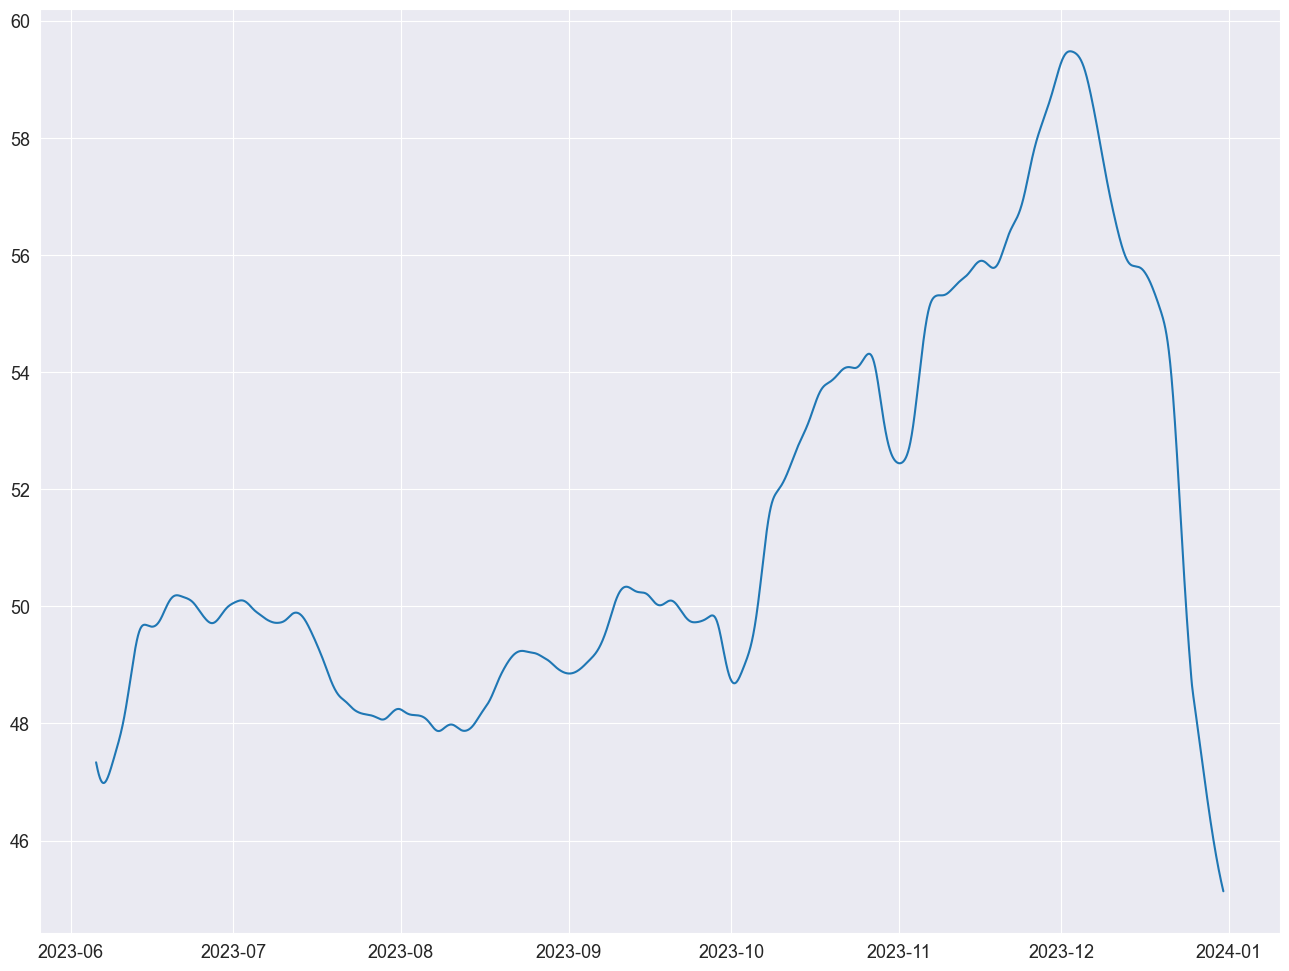

In [60]:
plt.plot(res.trend[-5000:])

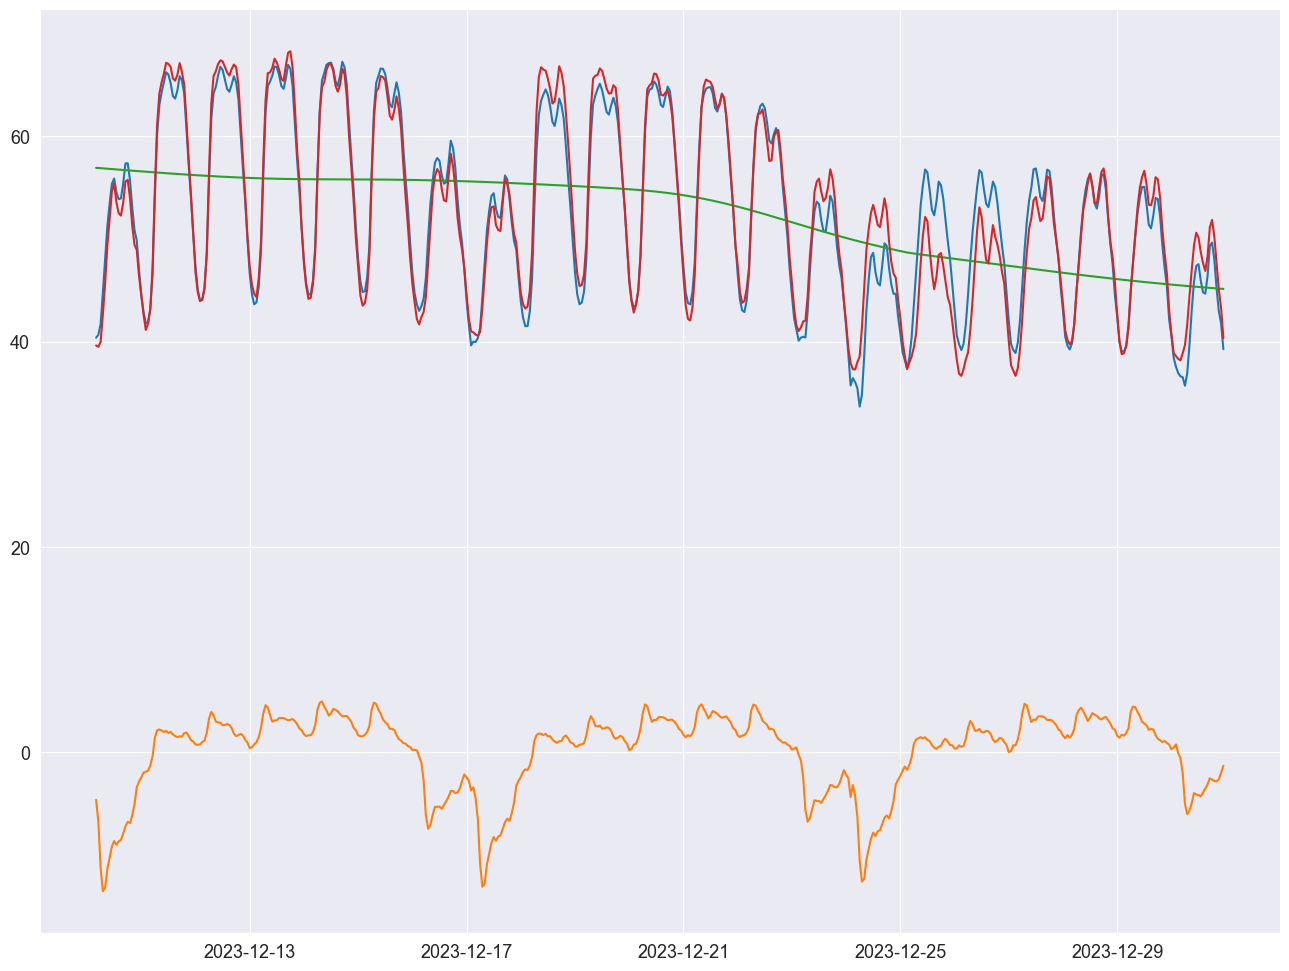

In [84]:
d = pd.DataFrame(res.seasonal.seasonal_24[-500:] + res.seasonal.seasonal_168[-500:] + res.trend[-500:])
d.columns = ['24p168_trend']
d['weekly'] = res.seasonal.seasonal_168[-500:]
d['trend'] = res.trend
d['obs'] = df
plt.plot(d)

In [78]:
d

,24p168,obs
date_time,,
2023-12-10 04:00:00,-16.551804,39.62375
2023-12-10 05:00:00,-16.267510,39.48575
2023-12-10 06:00:00,-15.192752,39.95425
2023-12-10 07:00:00,-12.122425,42.64350
2023-12-10 08:00:00,-8.901641,45.71425
...,...,...
2023-12-30 19:00:00,2.793425,50.22900
2023-12-30 20:00:00,-0.000177,47.60575
2023-12-30 21:00:00,-2.212525,45.04200


In [74]:
d

date_time
2023-12-10 04:00:00   -16.551804
2023-12-10 05:00:00   -16.267510
2023-12-10 06:00:00   -15.192752
2023-12-10 07:00:00   -12.122425
2023-12-10 08:00:00    -8.901641
                         ...    
2023-12-30 20:00:00    -0.000177
2023-12-30 21:00:00    -2.212525
2023-12-30 22:00:00    -3.377827
2023-12-30 23:00:00    -5.875632
obs                     0.000000
Length: 501, dtype: float64

# Forecast using STL

In [1]:
from sktime.datasets import load_airline
from sktime.forecasting.statsforecast import StatsForecastMSTL

In [96]:
import pandas as pd
start_date = pd.to_datetime("2023-01-01")
end_date = pd.to_datetime("2023-12-08")

mask = (df.index >= start_date) & (df.index < end_date)
y = df[mask]
model = StatsForecastMSTL(season_length=[24,24*7]) 
fitted_model = model.fit(y=y) 
y_pred = fitted_model.predict(fh=[i for i in range(1,500)]) 

In [97]:
start_date = pd.to_datetime("2023-12-08")
end_date = pd.to_datetime("2023-12-12")

mask = (df.index >= start_date) & (df.index < end_date)
obs = df[mask]

(19698.0, 19703.0)

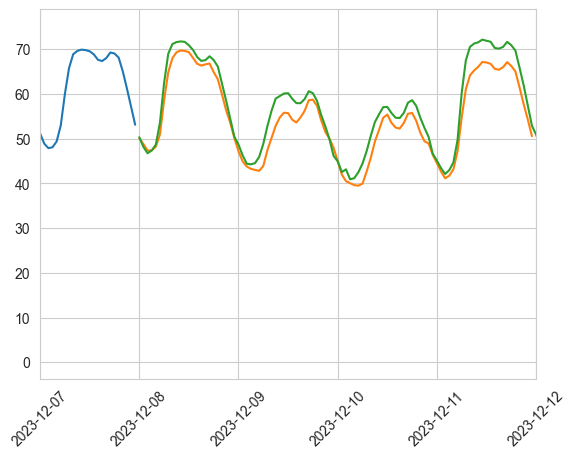

In [99]:
import matplotlib.pyplot as plt
# y.index = y.index.to_timestamp()
plt.plot(y)

plt.plot(obs)
plt.plot(y_pred)
plt.xticks(rotation=45)
plt.xlim(pd.to_datetime("2023-12-07"),pd.to_datetime("2023-12-12"))

In [100]:
print(y_pred.loc["2023-12-08"])

                        gesamt
2023-12-08 00:00:00  50.329128
2023-12-08 01:00:00  48.147905
2023-12-08 02:00:00  46.753512
2023-12-08 03:00:00  47.374257
2023-12-08 04:00:00  48.661769
2023-12-08 05:00:00  53.610249
2023-12-08 06:00:00  62.459413
2023-12-08 07:00:00  68.992501
2023-12-08 08:00:00  71.173901
2023-12-08 09:00:00  71.618405
2023-12-08 10:00:00  71.771815
2023-12-08 11:00:00  71.667816
2023-12-08 12:00:00  70.900338
2023-12-08 13:00:00  69.862366
2023-12-08 14:00:00  68.288110
2023-12-08 15:00:00  67.414373
2023-12-08 16:00:00  67.582331
2023-12-08 17:00:00  68.451237
2023-12-08 18:00:00  67.589996
2023-12-08 19:00:00  66.149157
2023-12-08 20:00:00  62.332220
2023-12-08 21:00:00  58.550366
2023-12-08 22:00:00  54.490740
2023-12-08 23:00:00  50.433696


In [101]:
print(obs.loc["2023-12-08"])

                       gesamt
date_time                    
2023-12-08 00:00:00  50.16150
2023-12-08 01:00:00  48.78950
2023-12-08 02:00:00  47.37100
2023-12-08 03:00:00  47.36450
2023-12-08 04:00:00  48.23550
2023-12-08 05:00:00  50.96975
2023-12-08 06:00:00  58.60550
2023-12-08 07:00:00  64.83275
2023-12-08 08:00:00  67.99450
2023-12-08 09:00:00  69.34875
2023-12-08 10:00:00  69.74475
2023-12-08 11:00:00  69.64000
2023-12-08 12:00:00  69.36500
2023-12-08 13:00:00  68.08300
2023-12-08 14:00:00  66.76475
2023-12-08 15:00:00  66.35975
2023-12-08 16:00:00  66.63550
2023-12-08 17:00:00  66.83200
2023-12-08 18:00:00  64.91550
2023-12-08 19:00:00  63.29175
2023-12-08 20:00:00  59.92875
2023-12-08 21:00:00  56.38850
2023-12-08 22:00:00  53.58850
2023-12-08 23:00:00  50.16250
